In [6]:
import matplotlib.pyplot as plt 
from NRoutines.assemutil import DME_heat, assembler_heat, loadasem
from NRoutines.gaussutil import  gauss_1d, gauss_nd
from NRoutines.uelutil import elast_quad4
from NRoutines.femutil import jacoper, elast_diff_2d, shape_quad4
from NRoutines.postprocesor import complete_disp, heat_nodes
import numpy as np

In [7]:
def readin():
    nodes    = np.loadtxt('Files/' + 'nodes.txt', ndmin=2)
    mats     = np.loadtxt('Files/' + 'mater.txt', ndmin=2)
    elements = np.loadtxt('Files/' + 'eles.txt', ndmin=2, dtype=int)
    loads    = np.loadtxt('Files/' + 'loads.txt', ndmin=2)

    return nodes, mats, elements, loads

In [8]:
nodes, mats, elements, loads = readin()

In [9]:
DME, IBC, neq = DME_heat(nodes, elements)

1
1
1
1


In [10]:
DME

array([[-1, -1,  5,  4],
       [-1, -1,  2,  5],
       [ 4,  5,  3,  1],
       [ 5,  2,  0,  3]])

In [11]:
IBC

array([-1, -1,  0,  1, -1,  2,  3,  4,  5])

In [12]:
KG = assembler_heat(elements, mats, nodes, neq, DME)
KG

array([[ 0.66666667,  0.        , -0.16666667, -0.16666667,  0.        ,
        -0.33333333],
       [ 0.        ,  0.66666667,  0.        , -0.16666667, -0.16666667,
        -0.33333333],
       [-0.16666667,  0.        ,  1.33333333, -0.33333333,  0.        ,
        -0.33333333],
       [-0.16666667, -0.16666667, -0.33333333,  1.33333333, -0.33333333,
        -0.33333333],
       [ 0.        , -0.16666667,  0.        , -0.33333333,  1.33333333,
        -0.33333333],
       [-0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333,
         2.66666667]])

In [13]:
loads

array([[3., 1.],
       [6., 1.],
       [2., 1.]])

In [14]:
RHS = loadasem(loads, IBC, neq)
RHS

array([1., 1., 0., 1., 0., 0.])

In [15]:
from numpy.linalg import solve

U_sol = solve(KG, RHS)
U_sol

array([3.30612245, 3.30612245, 1.46938776, 2.69387755, 1.46938776,
       1.53061224])

In [16]:
UC = complete_disp(IBC, nodes, U_sol)
UC

array([0.        , 0.        , 3.30612245, 3.30612245, 0.        ,
       1.46938776, 2.69387755, 1.46938776, 1.53061224])

In [17]:
T_nodes, q_nodes = heat_nodes(nodes, elements, 1, UC)
T_nodes


array([[ 1.29382571e-02,  1.48232601e+00],
       [-1.29382571e-02,  1.48232601e+00],
       [ 4.69924070e-01,  1.69441387e+00],
       [-4.69924070e-01,  1.69441387e+00],
       [ 5.55111512e-17,  1.51767399e+00],
       [ 1.64050526e-02,  1.58836994e+00],
       [ 4.44089210e-16,  1.30558613e+00],
       [-1.64050526e-02,  1.58836994e+00],
       [ 0.00000000e+00,  1.41163006e+00]])

In [18]:
q_nodes

array([[-1.29382571e-02, -1.48232601e+00],
       [ 1.29382571e-02, -1.48232601e+00],
       [-4.69924070e-01, -1.69441387e+00],
       [ 4.69924070e-01, -1.69441387e+00],
       [-5.55111512e-17, -1.51767399e+00],
       [-1.64050526e-02, -1.58836994e+00],
       [-4.44089210e-16, -1.30558613e+00],
       [ 1.64050526e-02, -1.58836994e+00],
       [ 0.00000000e+00, -1.41163006e+00]])

In [19]:
def plot_field_contour(nodes, elements, values, title="Field Variable", 
                      xlabel="x", ylabel="y", colormap='YlGnBu', 
                      figsize=(8, 6), levels=15, showmesh=False):
    """
    Plot FEM results as a filled contour plot.
    
    Parameters
    ----------
    nodes : ndarray
        Nodal coordinates array (n_nodes x 3) [node_id, x, y]
    elements : ndarray
        Element connectivity array
    values : ndarray
        Values to plot at each node
    title : str, optional
        Title for the plot
    xlabel : str, optional
        Label for x axis
    ylabel : str, optional
        Label for y axis
    colormap : str, optional
        Matplotlib colormap name
    figsize : tuple, optional
        Figure size in inches
    levels : int, optional
        Number of contour levels
    showmesh : bool, optional
        Whether to show the mesh lines
    """
    import matplotlib.pyplot as plt
    from matplotlib.tri import Triangulation
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Extract coordinates and create triangulation
    x = nodes[:, 1]
    y = nodes[:, 2]
    
    # For quad elements, need to split each quad into two triangles
    triangles = []
    for element in elements[:, 3:]:  # Skip first 3 columns [ele_id, ele_type, mat]
        # Split quad into two triangles
        triangles.append([element[0], element[1], element[2]])
        triangles.append([element[0], element[2], element[3]])
    
    # Create triangulation
    triang = Triangulation(x, y, triangles)
    
    # Create filled contour plot
    plt.tricontourf(triang, values, levels=levels, cmap=colormap)
    
    # Add colorbar
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=10)
    
    # Add mesh if requested
    if showmesh:
        plt.triplot(triang, 'k-', lw=0.5, alpha=0.3)
    
    # Set labels and title
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14)
    
    # Make it look nice
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    
    return plt.gca()

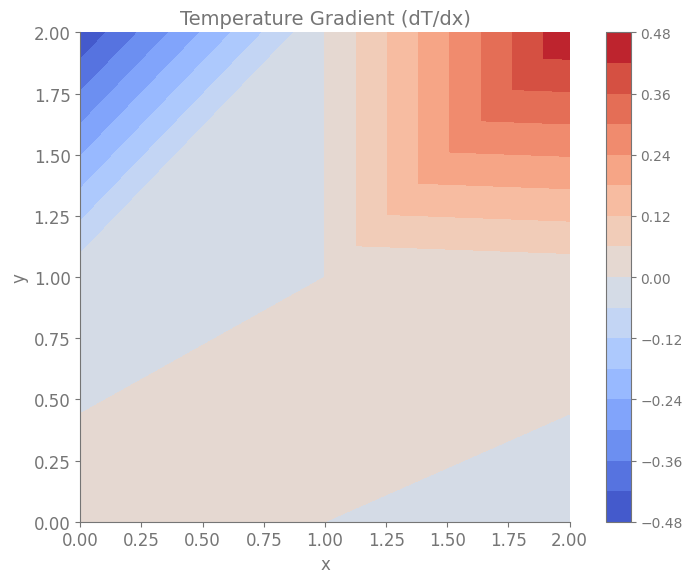

In [20]:
#Ejemplo de uso:
#Para gradientes de temperatura (dT/dx)
plot_field_contour(nodes, elements, T_nodes[:,0], 
                  title="Temperature Gradient (dT/dx)",
                  colormap='coolwarm')
plt.show()



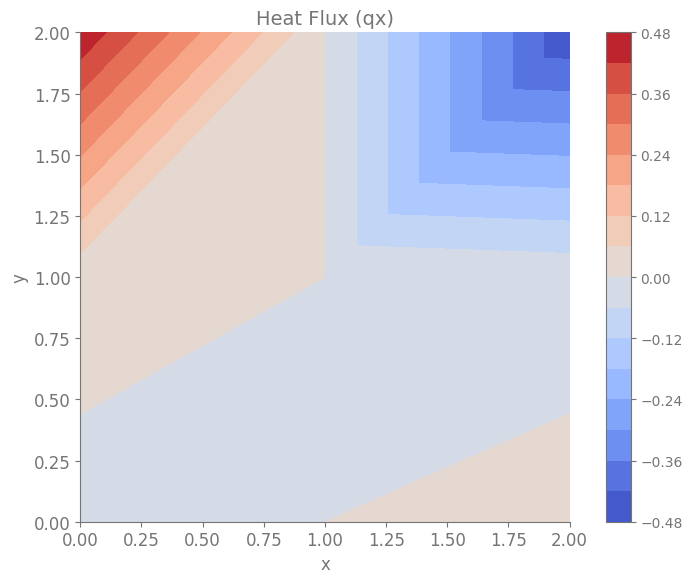

In [21]:
#Para flujo de calor (qx)
plot_field_contour(nodes, elements, q_nodes[:, 0],
                  title="Heat Flux (qx)",
                  colormap='coolwarm')
plt.show()
